In [ ]:
import csv
import os
import shutil
import subprocess
import warnings
from operator import itemgetter
from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rstoolbox as rsb
import seaborn as sns
from Bio.PDB import *
from Bio.PDB.DSSP import DSSP
from scipy.spatial import cKDTree
from statannot import add_stat_annotation
from tqdm import tqdm

warnings.filterwarnings("ignore")


In [2]:
def collect_scores(matches_dir: str) -> Tuple[list, pd.DataFrame]:
    """Collect scores from MaSIF-sim matches.

    Args:
        matches_dir (str): Path to the match directory (typically `out_peptides`).

    Returns:
        tuple[list, pd.DataFrame]: List with paths do all matched PDB file and Pandas DataFrame containing the scores.
    """
    score_files = []
    pdb_files = []
    for root, dirs, files in tqdm(os.walk(matches_dir)):
        for f in files:
            if f.endswith('.score'):
                score_files.append(os.path.join(root, f))
            elif f.endswith('.pdb'):
                pdb_files.append(os.path.join(root, f))

    with open(os.path.join(matches_dir,'matches.list'), 'w') as outfile:
        outfile.write('\n'.join(pdb_files))

    scores = []
    for f in tqdm(score_files):
        if os.stat(f).st_size != 0:
            with open(f, 'r') as infile:
                content = infile.read().split(' ')
                try:
                    scores.append([x.strip(',\n') for x in itemgetter(1,4,6,12,8,10,14)(content)])
                except IndexError:
                    site_id = f.split('/')[-3].split('_')[-1]
                    scores.append([x.strip(',\n') for x in itemgetter(1,4,6,12,8,10)(content)] + [site_id])

    header = ['pdb', 'point_id', 'nn_score', 'desc_dist_score', 'clashing_ca', 'clashing_heavy', 'site_id']
    with open(os.path.join(matches_dir, 'scores.csv'), 'w') as outfile:
        write = csv.writer(outfile)
        write.writerow(header)
        write.writerows(scores)

    scores_df = pd.DataFrame(scores, columns=header)
    scores_df['pdb'] =  scores_df['pdb'].astype(str)
    scores_df['point_id'] =  scores_df['point_id'].astype(int)
    scores_df['nn_score'] =  scores_df['nn_score'].astype(float)
    scores_df['desc_dist_score'] =  scores_df['desc_dist_score'].astype(float)
    scores_df['clashing_ca'] =  scores_df['clashing_ca'].astype(int)
    scores_df['clashing_heavy'] =  scores_df['clashing_heavy'].astype(int)
    scores_df['site_id'] =  scores_df['site_id'].astype(int)

    return pdb_files, scores_df

In [3]:
def contacts_per_dssp(pdb: str, seed_chain: str, target_chain: str, dist_cutoff: float=5.0) -> list:
    """Assign DSSP to seed residues and check how many interactions each residues
    contributes to the overall interface within `dist_cutoff`.

    Args:
        pdb (str): Path to PDB.
        seed_chain (str): Seed chain ID.
        target_chain (str): Target chain ID
        dist_cutoff (float, optional): Cutoff distance in Angstrom within which residues are considered to make contacts. Defaults to 5.0.

    Returns:
        list: List containing annotation for each seed residue in the from ['DSSP', 'ResidueID', 'NumberOfContacts']
    """
    
    parser = PDBParser()
    results = []

    # Load target and seed structures
    try:
        pdb_name = pdb
        pdb_struct = parser.get_structure(pdb_name, pdb_name)
    except:
        print('Error with {}'.format(pdb_name))

    model_pdb = pdb_struct[0]

    atoms_target = Selection.unfold_entities(model_pdb[target_chain], 'A')
    atoms_seed = Selection.unfold_entities(model_pdb[seed_chain], 'A')
    res_seed = []
    for res in Selection.unfold_entities(model_pdb[seed_chain], 'R'):
        # Only keep canonical amino acids
        try:
            if Polypeptide.three_to_index(res.get_resname()) <= 19:
                res_seed.append(res)
        except KeyError as err:
            print(err, res)
            continue

    dssp_pdb = DSSP(model_pdb, pdb_name, dssp='/bin/dssp')

    coords_target = [x.get_coord() for x in atoms_target]
    coords_seed = [x.get_coord() for x in atoms_seed]

    ckd = cKDTree(coords_target)
    dists_seed_to_target, r = ckd.query(coords_seed)

    # Get the residues in the interface
    interface = np.where(dists_seed_to_target < dist_cutoff)[0]
    resid_interface = [atoms_seed[x].get_parent().get_id()[1] for x in interface]

    chain_dssp = {}
    chain_dssp_ids = []
    res_seed_ids = [res.get_id() for res in res_seed]
    for key in dssp_pdb.keys():
        if key[0] == seed_chain:# and key[1] in res_A_ids:
            chain_dssp.update({key: dssp_pdb[key]})
            chain_dssp_ids.append(key[1])
    chain_dssp_string = (''.join([i[2] for i in chain_dssp.values()]))
    # Check how many contacts each residue makes and which DSSP type that residue has
    for ix, elem in enumerate(chain_dssp.keys()):
        resid = res_seed[ix].get_id()[1]
        if resid in resid_interface and elem[0] == seed_chain:
            results.append([chain_dssp_string[ix], resid, resid_interface.count(resid)])
    return results

In [4]:
def get_fasta(pdbfile: str) -> dict:
    """Retrieve amino acid sequence from PDB structure file.

    Args:
        pdbfile (str): Path to PDB file.

    Returns:
        dict: Dictionary with chain IDs as keys and amino acid sequences as value.
    """
    protein_letters_3to1 = {'ala': 'A',
 'cys': 'C',
 'asp': 'D',
 'glu': 'E',
 'phe': 'F',
 'gly': 'G',
 'his': 'H',
 'ile': 'I',
 'lys': 'K',
 'leu': 'L',
 'met': 'M',
 'asn': 'N',
 'pro': 'P',
 'gln': 'Q',
 'arg': 'R',
 'ser': 'S',
 'thr': 'T',
 'val': 'V',
 'trp': 'W',
 'tyr': 'Y'}

    with open(pdbfile, 'r') as infile:
        content = infile.read().splitlines()

    fastaseq = {}
    resnum_buffer = 0
    for line in content:
        if line.startswith('ATOM'):
            resnum = int(line[22:27].strip(' '))
            if resnum == resnum_buffer:
                continue
            else:
                resnum_buffer = resnum
                residue_letter = protein_letters_3to1[line[17:20].lower()]
                chain = line[21]
                try:
                    fastaseq[chain] += residue_letter
                except KeyError:
                    fastaseq[chain] = residue_letter
    return fastaseq

In [5]:
def get_origin(desc):
    if len(desc.split('_')[0]) == 5:
        return 'PDB'
    elif desc.split('_')[0].startswith('AF'):
        return 'AF'
    else:
        return 'mini'

In [6]:
def get_seed_id(seed):
    if seed.split('_')[-1].startswith('S'):
        return int(seed.split('_')[-1].lstrip('S'))
    elif seed.split('_')[-2].startswith('S'):
        return int(seed.split('_')[-2].lstrip('S'))
    else:
        print(seed)
        raise ValueError

# Collect MaSIF matches and scores

In [8]:
base_dir = '../masif_seed_search/data/masif_targets/targets/5jds_A/'
match_dir = os.path.join(base_dir, 'out_peptides')
seed_pipeline = '../rosetta_scripts/'
seed_refine_pipeline = os.path.join(seed_pipeline, 'seed_refine')
seed_motifgraft_pipeline = os.path.join(seed_pipeline, 'seed_grafting_beta')

In [ ]:
matches, scores = collect_scores(match_dir)

In [9]:
matches = []
with open(os.path.join(match_dir, 'matches.list'), newline='') as csvfile:
    matches_files = csv.reader(csvfile, delimiter=',')
    for row in matches_files:
        matches.append(row[0])

In [10]:
scores = pd.read_csv(os.path.join(match_dir, 'scores.csv'))

# Refine seeds

In [11]:
refined_dir = os.path.join(base_dir, 'refined_seeds')
os.makedirs(refined_dir, exist_ok=True)

In [22]:
with open(os.path.join(refined_dir, 'input.list'), 'w') as f:
    f.write('\n'.join([target + ' ' + m for m in matches]))


In [23]:
os.makedirs(os.path.join(refined_dir, 'tmp'), exist_ok=True)
os.makedirs(os.path.join(refined_dir, 'relax'), exist_ok=True)
os.makedirs(os.path.join(refined_dir, 'refined'), exist_ok=True)
os.makedirs(os.path.join(refined_dir, 'logs'), exist_ok=True)

In [ ]:
shutil.copy2(os.path.join(seed_refine_pipeline, 'refinement', 'relax.xml'), refined_dir)
shutil.copy2(os.path.join(seed_refine_pipeline, 'refinement', 'interface_design.xml'), refined_dir)
shutil.copy2(os.path.join(seed_refine_pipeline, 'refinement', 'no_ref.rosettacon2018.beta_nov16.txt'), refined_dir)

In [25]:
refinment_submitter = f'''#!/bin/bash
#SBATCH --nodes 1
#SBATCH --ntasks-per-node 1
#SBATCH --cpus-per-task 1
#SBATCH --mem 8192
#SBATCH --time 1:00:00
#SBATCH --job-name="{target.split('/')[-1].split('.')[0]}_refine"
#SBATCH --array=1-{len(matches)}
#SBATCH --output=./logs/{target.split('/')[-1].split('.')[0]}.%A_%a.out
#SBATCH --error=./logs/{target.split('/')[-1].split('.')[0]}.%A_%a.err

ROSETTA_BIN=/bin/rosetta_scripts.linuxiccrelease

LINE=$(sed -n "$SLURM_ARRAY_TASK_ID"p input.list)
MYID=$SLURM_ARRAY_TASK_ID
SEED_PATH=$(echo $LINE | awk '{{print $2;}}')
SEED_NAME=$(basename $SEED_PATH | cut -d "." -f1)
TARGET_PATH=$(echo $LINE | awk '{{print $1;}}')
TARGET_NAME=$(basename $TARGET_PATH | cut -d "." -f1)
IN_FILE=./relax/$TARGET_NAME\_$SEED_NAME.pdb
echo $LINE > ./tmp/tmp_list_$MYID.txt

$ROSETTA_BIN -parser:protocol relax.xml \\
    -list ./tmp/tmp_list_$MYID.txt \\
    -no_nstruct_label \\
    -out:path:all ./relax\\
    -overwrite \\
    -renumber_pdb

$ROSETTA_BIN -parser:protocol interface_design2.xml \\
    -s $IN_FILE \\
    -no_nstruct_label \\
    -out:path:all ./refined \\
    -overwrite \\
    -renumber_pdb \\
    -holes:dalphaball  /bin/DAlphaBall.gcc

rm ./tmp/tmp_list_$MYID.txt
'''

with open(os.path.join(refined_dir, 'submitter_full.slurm'), 'w') as f:
    f.write(refinment_submitter)

In [ ]:
os.chdir(refined_dir)
subprocess.call(['sbatch', os.path.join(refined_dir, 'submitter_full.slurm')])

In [12]:
results_reference_list = [f'{target.split("/")[-1].split(".")[0]}_{m.split("/")[-1].split(".")[0]}' for m in matches]

In [13]:
relax_scores = rsb.io.parse_rosetta_file(os.path.join(refined_dir, 'relax', 'score.sc'))

In [14]:
refined_scores = rsb.io.parse_rosetta_file(os.path.join(refined_dir, 'refined', 'score.sc'))

In [15]:
refined_scores['nddg_pre'] = refined_scores['ddg_pre'] / refined_scores['sasa_pre'] * 1000
refined_scores['nddg_post'] = refined_scores['ddg_post'] / refined_scores['sasa_post'] * 1000
refined_scores['seed'] = refined_scores['description'].apply(lambda x: x.replace(target.split("/")[-1].split(".")[0] + '_', ''))


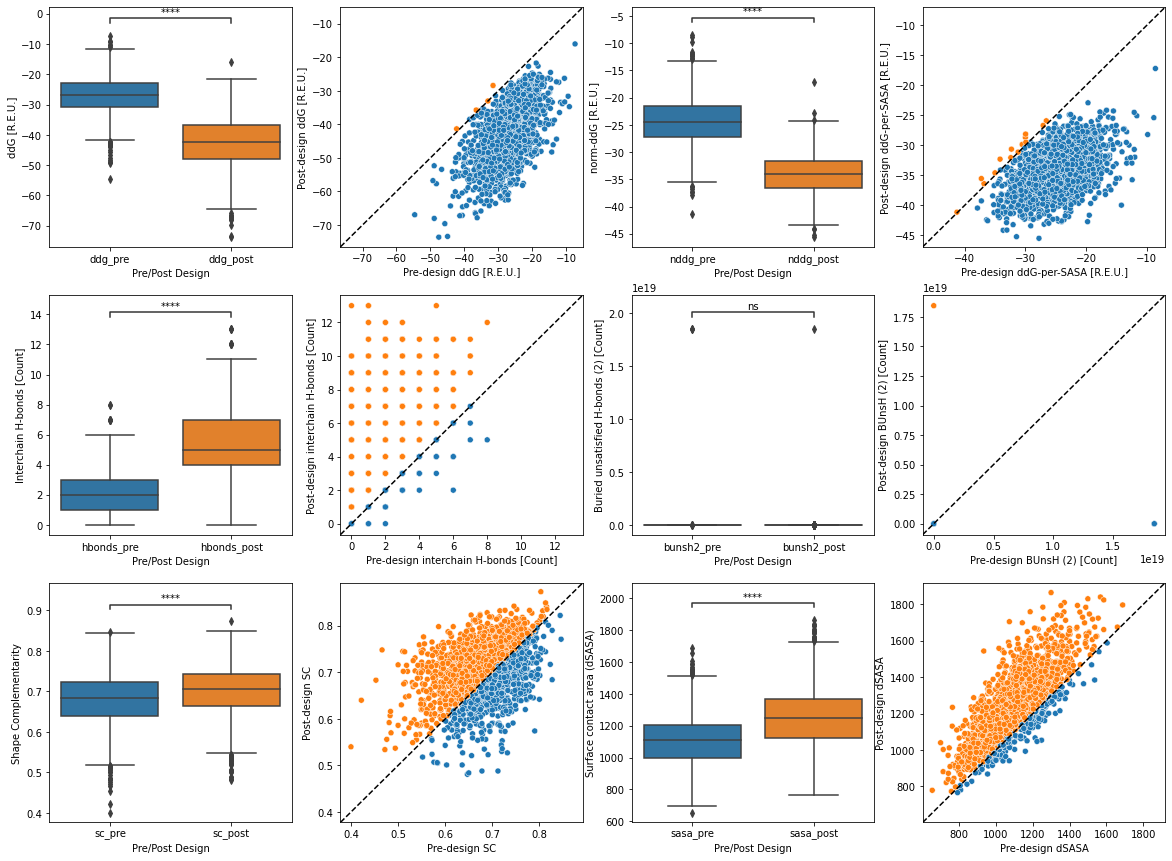

In [20]:
fig, ax = plt.subplots(3, 4, figsize=(20, 15))

# ddG
p = sns.boxplot(
    x="variable",
    y="value",
    data=pd.melt(refined_scores[["ddg_pre", "ddg_post"]]),
    ax=ax[0][0],
)
add_stat_annotation(
    p,
    x="variable",
    y="value",
    data=pd.melt(refined_scores[["ddg_pre", "ddg_post"]]),
    order=["ddg_pre", "ddg_post"],
    box_pairs=[("ddg_pre", "ddg_post")],
    test="t-test_ind",
    text_format="star",
    loc="inside",
    verbose=0,
)
ax[0][0].set_xlabel("Pre/Post Design")
ax[0][0].set_ylabel("ddG [R.E.U.]")

p = sns.scatterplot(
    x="ddg_pre",
    y="ddg_post",
    hue=refined_scores["ddg_post"] > refined_scores["ddg_pre"],
    data=refined_scores,
    legend=False,
    ax=ax[0][1],
)
x0, y0 = p.get_xlim()
x1, y1 = p.get_ylim()
x2 = min([x0, x1])
y2 = max([y0, y1])
p.set_xlim(left=x2, right=y2)
p.set_ylim(bottom=x2, top=y2)
ax[0][1].set_xlabel("Pre-design ddG [R.E.U.]")
ax[0][1].set_ylabel("Post-design ddG [R.E.U.]")
x0, y0 = p.get_xlim()
x1, y1 = p.get_ylim()
ax[0][1].plot([x0, y0], [x1, y1], "k--")

# norm. ddG
p = sns.boxplot(
    x="variable",
    y="value",
    data=pd.melt(refined_scores[["nddg_pre", "nddg_post"]]),
    ax=ax[0][2],
)
add_stat_annotation(
    p,
    x="variable",
    y="value",
    data=pd.melt(refined_scores[["nddg_pre", "nddg_post"]]),
    order=["nddg_pre", "nddg_post"],
    box_pairs=[("nddg_pre", "nddg_post")],
    test="t-test_ind",
    text_format="star",
    loc="inside",
    verbose=0,
)
ax[0][2].set_xlabel("Pre/Post Design")
ax[0][2].set_ylabel("norm-ddG [R.E.U.]")

p = sns.scatterplot(
    x="nddg_pre",
    y="nddg_post",
    hue=refined_scores["nddg_post"] > refined_scores["nddg_pre"],
    data=refined_scores,
    legend=False,
    ax=ax[0][3],
)
x0, y0 = p.get_xlim()
x1, y1 = p.get_ylim()
x2 = min([x0, x1])
y2 = max([y0, y1])
p.set_xlim(left=x2, right=y2)
p.set_ylim(bottom=x2, top=y2)
ax[0][3].set_xlabel("Pre-design ddG-per-SASA [R.E.U.]")
ax[0][3].set_ylabel("Post-design ddG-per-SASA [R.E.U.]")
x0, y0 = p.get_xlim()
x1, y1 = p.get_ylim()
ax[0][3].plot([x0, y0], [x1, y1], "k--")

# Hbonds
p = sns.boxplot(
    x="variable",
    y="value",
    data=pd.melt(refined_scores[["hbonds_pre", "hbonds_post"]]),
    ax=ax[1][0],
)
add_stat_annotation(
    p,
    x="variable",
    y="value",
    data=pd.melt(refined_scores[["hbonds_pre", "hbonds_post"]]),
    order=["hbonds_pre", "hbonds_post"],
    box_pairs=[("hbonds_pre", "hbonds_post")],
    test="t-test_ind",
    text_format="star",
    loc="inside",
    verbose=0,
)
ax[1][0].set_xlabel("Pre/Post Design")
ax[1][0].set_ylabel("Interchain H-bonds [Count]")

p = sns.scatterplot(
    x="hbonds_pre",
    y="hbonds_post",
    hue=refined_scores["hbonds_post"] > refined_scores["hbonds_pre"],
    data=refined_scores,
    legend=False,
    ax=ax[1][1],
)
x0, y0 = p.get_xlim()
x1, y1 = p.get_ylim()
x2 = min([x0, x1])
y2 = max([y0, y1])
p.set_xlim(left=x2, right=y2)
p.set_ylim(bottom=x2, top=y2)
ax[1][1].set_xlabel("Pre-design interchain H-bonds [Count]")
ax[1][1].set_ylabel("Post-design interchain H-bonds [Count]")
x0, y0 = p.get_xlim()
x1, y1 = p.get_ylim()
ax[1][1].plot([x0, y0], [x1, y1], "k--")

# BUNS
p = sns.boxplot(
    x="variable",
    y="value",
    data=pd.melt(refined_scores[["bunsh2_pre", "bunsh2_post"]]),
    ax=ax[1][2],
)
add_stat_annotation(
    p,
    x="variable",
    y="value",
    data=pd.melt(refined_scores[["bunsh2_pre", "bunsh2_post"]]),
    order=["bunsh2_pre", "bunsh2_post"],
    box_pairs=[("bunsh2_pre", "bunsh2_post")],
    test="t-test_ind",
    text_format="star",
    loc="inside",
    verbose=0,
)
ax[1][2].set_xlabel("Pre/Post Design")
ax[1][2].set_ylabel("Buried unsatisfied H-bonds (2) [Count]")

p = sns.scatterplot(
    x="bunsh2_pre",
    y="bunsh2_post",
    hue=refined_scores["bunsh2_post"] > refined_scores["bunsh2_pre"],
    data=refined_scores,
    legend=False,
    ax=ax[1][3],
)
x0, y0 = p.get_xlim()
x1, y1 = p.get_ylim()
x2 = min([x0, x1])
y2 = max([y0, y1])
p.set_xlim(left=x2, right=y2)
p.set_ylim(bottom=x2, top=y2)
ax[1][3].set_xlabel("Pre-design BUnsH (2) [Count]")
ax[1][3].set_ylabel("Post-design BUnsH (2) [Count]")
x0, y0 = p.get_xlim()
x1, y1 = p.get_ylim()
ax[1][3].plot([x0, y0], [x1, y1], "k--")

# SC
p = sns.boxplot(
    x="variable",
    y="value",
    data=pd.melt(refined_scores[["sc_pre", "sc_post"]]),
    ax=ax[2][0],
)
add_stat_annotation(
    p,
    x="variable",
    y="value",
    data=pd.melt(refined_scores[["sc_pre", "sc_post"]]),
    order=["sc_pre", "sc_post"],
    box_pairs=[("sc_pre", "sc_post")],
    test="t-test_ind",
    text_format="star",
    loc="inside",
    verbose=0,
)
ax[2][0].set_xlabel("Pre/Post Design")
ax[2][0].set_ylabel("Shape Complementarity")

p = sns.scatterplot(
    x="sc_pre",
    y="sc_post",
    hue=refined_scores["sc_post"] > refined_scores["sc_pre"],
    data=refined_scores,
    legend=False,
    ax=ax[2][1],
)
x0, y0 = p.get_xlim()
x1, y1 = p.get_ylim()
x2 = min([x0, x1])
y2 = max([y0, y1])
p.set_xlim(left=x2, right=y2)
p.set_ylim(bottom=x2, top=y2)
ax[2][1].set_xlabel("Pre-design SC")
ax[2][1].set_ylabel("Post-design SC")
x0, y0 = p.get_xlim()
x1, y1 = p.get_ylim()
ax[2][1].plot([x0, y0], [x1, y1], "k--")

# dSASA
p = sns.boxplot(
    x="variable",
    y="value",
    data=pd.melt(refined_scores[["sasa_pre", "sasa_post"]]),
    ax=ax[2][2],
)
add_stat_annotation(
    p,
    x="variable",
    y="value",
    data=pd.melt(refined_scores[["sasa_pre", "sasa_post"]]),
    order=["sasa_pre", "sasa_post"],
    box_pairs=[("sasa_pre", "sasa_post")],
    test="t-test_ind",
    text_format="star",
    loc="inside",
    verbose=0,
)
ax[2][2].set_xlabel("Pre/Post Design")
ax[2][2].set_ylabel("Surface contact area (dSASA)")

p = sns.scatterplot(
    x="sasa_pre",
    y="sasa_post",
    hue=refined_scores["sasa_post"] > refined_scores["sasa_pre"],
    data=refined_scores,
    legend=False,
    ax=ax[2][3],
)
x0, y0 = p.get_xlim()
x1, y1 = p.get_ylim()
x2 = min([x0, x1])
y2 = max([y0, y1])
p.set_xlim(left=x2, right=y2)
p.set_ylim(bottom=x2, top=y2)
ax[2][3].set_xlabel("Pre-design dSASA")
ax[2][3].set_ylabel("Post-design dSASA")
x0, y0 = p.get_xlim()
x1, y1 = p.get_ylim()
ax[2][3].plot([x0, y0], [x1, y1], "k--")


In [21]:
print(f"Pre-ddG: {refined_scores['ddg_pre'].mean()} / Post-ddG: {refined_scores['ddg_post'].mean()} / Improvement rate: {(refined_scores['ddg_post'].mean() - refined_scores['ddg_pre'].mean())/refined_scores['ddg_pre'].mean()*100}%")
print(f"Pre-nddG: {refined_scores['nddg_pre'].mean()} / Post-nddG: {refined_scores['nddg_post'].mean()} / Improvement rate: {(refined_scores['nddg_post'].mean() - refined_scores['nddg_pre'].mean())/refined_scores['nddg_pre'].mean()*100}%")
print(f"Pre-Hbonds: {refined_scores['hbonds_pre'].mean()} / Post-Hbonds: {refined_scores['hbonds_post'].mean()} / Improvement rate: {(refined_scores['hbonds_post'].mean() - refined_scores['hbonds_pre'].mean())/refined_scores['hbonds_pre'].mean()*100}%")
print(f"Pre-BUNS: {refined_scores['bunsh2_pre'].mean()} / Post-BUNS: {refined_scores['bunsh2_post'].mean()} / Improvement rate: {(refined_scores['bunsh2_pre'].mean() - refined_scores['bunsh2_post'].mean())/refined_scores['bunsh2_pre'].mean()*100}%")
print(f"Pre-SC: {refined_scores['sc_pre'].mean()} / Post-SC: {refined_scores['sc_post'].mean()} / Improvement rate: {(refined_scores['sc_post'].mean() - refined_scores['sc_pre'].mean())/refined_scores['sc_pre'].mean()*100}%")
print(f"Pre-SASA: {refined_scores['sasa_pre'].mean()} / Post-SASA: {refined_scores['sasa_post'].mean()} / Improvement rate: {(refined_scores['sasa_post'].mean() - refined_scores['sasa_pre'].mean())/refined_scores['sasa_pre'].mean()*100}%")

Pre-ddG: -27.05282752808993 / Post-ddG: -42.59341516853929 / Improvement rate: 57.44533588702697%
Pre-nddG: -24.485977937762165 / Post-nddG: -34.0456312884538 / Improvement rate: 39.04133776069764%
Pre-Hbonds: 1.752808988764045 / Post-Hbonds: 5.285393258426966 / Improvement rate: 201.53846153846155%
Pre-BUNS: 3.109001810175767e+16 / Post-BUNS: 1.036333936725256e+16 / Improvement rate: 66.66666666666666%
Pre-SC: 0.6786544943820231 / Post-SC: 0.7010320224719107 / Improvement rate: 3.297337345457995%
Pre-SASA: 1107.7726191011247 / Post-SASA: 1249.3402713483151 / Improvement rate: 12.779486494445225%


In [16]:
scores['seed'] = scores.apply(lambda x: f"{x['pdb']}_{x['point_id']}", axis=1)

In [17]:
refined_scores = refined_scores.merge(on='seed', right=scores)

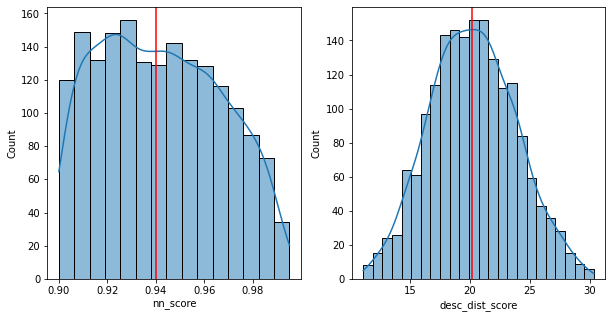

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))

# SASA
sns.histplot(refined_scores['nn_score'], kde=True, ax=ax[0])
ax[0].axvline(refined_scores['nn_score'].median(), color='red');

# ddG
sns.histplot(refined_scores['desc_dist_score'], kde=True, ax=ax[1])
ax[1].axvline(refined_scores['desc_dist_score'].median(), color='red');


# Top seeds for MotifGraft

In [ ]:
selected_seeds = refined_scores[
    (refined_scores["nddg_post"] < np.quantile(refined_scores["nddg_post"], 0.75))
    & (refined_scores["ddg_post"] < np.quantile(refined_scores["ddg_post"], 0.75))
    & (refined_scores["bunsh2_post"] <= 1)
    & (refined_scores["sc_post"] > 0.65)
    & (refined_scores["hbonds_post"] >= 0)
]

selected_seeds.shape


In [ ]:
selected_seeds.to_csv(os.path.join(refined_dir, 'selected_seeds.csv'))

In [26]:
os.makedirs(os.path.join(refined_dir, 'selected_seeds'), exist_ok=True)
for s in selected_seeds['description']:
    shutil.copy2(os.path.join(refined_dir, 'relax', s + '.pdb'), os.path.join(refined_dir, 'selected_seeds'))

In [49]:
beta_contacts_per_seed = []
for ss in tqdm(os.listdir(os.path.join(refined_dir, "selected_seeds"))):
    s = os.path.join(refined_dir, "selected_seeds", ss)
    contacts = pd.DataFrame(
        contacts_per_dssp(s, seed_chain="B", target_chain="A"),
        columns=["DSSP", "ResID", "NumContacts"],
    )
    all_contacts = contacts["NumContacts"].sum()
    dssp_B = 0
    dssp_E = 0
    try:
        dssp_B = contacts.groupby("DSSP").get_group("B").sum()["NumContacts"]
    except:
        pass
    try:
        dssp_E = contacts.groupby("DSSP").get_group("E").sum()["NumContacts"]
    except:
        pass
    beta_contacts = dssp_B + dssp_E
    beta_contacts_per_seed.append([ss.split(".")[0], beta_contacts / all_contacts])


100%|██████████| 312/312 [01:52<00:00,  2.77it/s]


In [50]:
beta_contacts_per_seed = pd.DataFrame(beta_contacts_per_seed, columns=['description', 'beta_contacts'])

In [51]:
selected_seeds = selected_seeds.merge(on='description', right=beta_contacts_per_seed)

In [ ]:
selected_beta_seeds = selected_seeds[selected_seeds['beta_contacts'] > 0.70]
selected_beta_seeds.shape

In [31]:
with open(os.path.join(refined_dir, 'mg.list'), 'w') as f:
    for s in selected_beta_seeds['description']:
        f.write(os.path.join(refined_dir, 'selected_seeds', s + '.pdb\n'))

# Motifgraft

In [ ]:
shutil.copy2(os.path.join(seed_motifgraft_pipeline, 'grafting_varhotspots.xml'), refined_dir)

In [33]:
prepare_seeds_slurm = f'''#!/bin/bash
#SBATCH --nodes 1
#SBATCH --partition=serial
#SBATCH --ntasks-per-node 1
#SBATCH --cpus-per-task 1
#SBATCH --mem 4096
#SBATCH --time 00:10:00
#SBATCH --job-name="{target.split('/')[-1].split('.')[0]}_prepare"
#SBATCH --array=1-{len(selected_beta_seeds)}
#SBATCH --output=./logs/prepare.%A_%a.out
#SBATCH --error=./logs/prepare.%A_%a.err

MYID=${{SLURM_ARRAY_TASK_ID}}
COMPLEX=$(sed -n "$SLURM_ARRAY_TASK_ID"p mg.list)
python3 ../rosetta_scripts/tools/extract_complex_multifrag.py $COMPLEX $MYID
python3 ../rosetta_scripts/tools/crop_seed.py $MYID
HOTSPOTS=$(python3 ../rosetta_scripts/tools/find_hotspots_multifrag.py $MYID)
NFRAGS=$(python3 ../rosetta_scripts/tools/find_nfrag.py $MYID)
echo "Hotspots: "$HOTSPOTS
echo "Number of fragments: "$NFRAGS
mkdir -p results/seed_$MYID

sbatch run_motif_graft_varhotspots.slurm $MYID $HOTSPOTS $NFRAGS
'''
with open(os.path.join(refined_dir, 'prepare_seeds.slurm'), 'w') as f:
    f.write(prepare_seeds_slurm)

In [34]:
motifgraft_slurm = f'''#!/bin/bash
#SBATCH --nodes 1
#SBATCH --partition=serial
#SBATCH --ntasks-per-node 1
#SBATCH --cpus-per-task 1
#SBATCH --mem 4096
#SBATCH --time 01:30:00
#SBATCH --job-name="{target.split('/')[-1].split('.')[0]}_mg"
#SBATCH --array=1-363
#SBATCH --output=./logs/mg.%A_%a.out
#SBATCH --error=./logs/mg.%A_%a.err

in_dir=../database/scaffolds
ROSETTA_BIN=/bin/rosetta_scripts.linuxiccrelease

MYID=${{SLURM_ARRAY_TASK_ID}}
UPPERID=$1
HOTSPOTS=$2
NFRAGS=$3
let TEMP=$NFRAGS-1
echo $TEMP

if [ $NFRAGS = 1 ]; then
    DELTA=''
else
    DELTA=$(printf '0:0,%0.s' $(seq $TEMP))
fi

DELTA=$DELTA'0:0'

mkdir -p results/seed_$UPPERID/$MYID
$ROSETTA_BIN -overwrite \\
         -ex1 -ex2 -ignore_zero_occupancy false \\
         -parser:protocol grafting_varhotspots2.xml\\
         -l $in_dir/splitfile_$MYID.split \\
         -ignore_unrecognized_res -nstruct 1 \\
         -out:path:all results/seed_$UPPERID/$MYID \\
         -parser:script_vars h=$HOTSPOTS s=$UPPERID c=$UPPERID f=$DELTA r=$DELTA\\
         -no_nstruct_label \\
         -out:suffix _S$UPPERID
'''
with open(os.path.join(refined_dir, 'run_motif_graft_varhotspots.slurm'), 'w') as f:
    f.write(motifgraft_slurm)

In [ ]:
os.chdir(refined_dir)
subprocess.call(['sbatch', os.path.join(refined_dir, 'prepare_seeds.slurm')])

# Analyze Motifgraft output

In [13]:
all_mg_scores = []
all_mg_pdbs = []
for root, dirs, files in os.walk(os.path.join(refined_dir, 'results')):
    for f in files:
        if f.endswith('.sc'):
            all_mg_scores.append(os.path.join(root, f))
        elif f.endswith('.pdb'):
            all_mg_pdbs.append(os.path.join(root, f))

In [15]:
all_dfs = []
for x in all_mg_scores:
    try:
        _ = rsb.io.parse_rosetta_file(x)
        _['scorefile_path'] = x
        all_dfs.append(_)
    except IndexError:
            try:
                _ = rsb.io.parse_rosetta_file(x, description={'graft_ranges': 2})
                _['scorefile_path'] = x
                all_dfs.append(_)
            except IndexError:
                try:
                    _ = rsb.io.parse_rosetta_file(x, description={'graft_ranges': 3})
                    _['scorefile_path'] = x
                    all_dfs.append(_)
                except IndexError:
                    pass

In [16]:
all_mg_scores_df = pd.concat(all_dfs)
all_mg_scores_df

,total_score,buried_unsat_hbonds,coordinate_constraint,ddG,dslf_fa13,fa_atr,fa_dun,fa_elec,fa_intra_rep,fa_intra_sol_xover4,...,graft_out_scaffold_ranges01,graft_out_scaffold_ranges02,graft_scaffold_size_change01,graft_scaffold_size_change02,description,scorefile_path,graft_in_motif_ranges03,graft_in_scaffold_ranges03,graft_out_scaffold_ranges03,graft_scaffold_size_change03
0,-494.036,2.0,9.734,-19.089,-1.169,-1019.643,200.611,-263.939,2.645,29.350,...,"146,151","158,160",0,0,4A48A_S38,/work/upcorreia/users/scheck/masif_pep/masif/masif_seed_search/data/masif_targets/targets/5jds_A/refined_seeds/results/seed_38/88/score_S38.sc,NaN,NaN,NaN,NaN
0,-612.663,0.0,8.608,-27.324,-1.130,-1113.234,228.107,-326.904,2.343,35.476,...,"159,161","163,168",0,0,3HTYD_S38,/work/upcorreia/users/scheck/masif_pep/masif/masif_seed_search/data/masif_targets/targets/5jds_A/refined_seeds/results/seed_38/56/score_S38.sc,NaN,NaN,NaN,NaN
0,-564.112,3.0,31.168,-28.906,-1.102,-1169.224,229.578,-328.531,2.734,35.335,...,"132,137","181,183",0,0,AF-O43678-F1-model_v1_S38,/work/upcorreia/users/scheck/masif_pep/masif/masif_seed_search/data/masif_targets/targets/5jds_A/refined_seeds/results/seed_38/21/score_S38.sc,NaN,NaN,NaN,NaN
0,-623.068,2.0,20.058,-34.431,-1.097,-1214.084,240.885,-338.920,2.576,38.106,...,"159,161","171,176",0,0,3PXMB_S38,/work/upcorreia/users/scheck/masif_pep/masif/masif_seed_search/data/masif_targets/targets/5jds_A/refined_seeds/results/seed_38/75/score_S38.sc,NaN,NaN,NaN,NaN
1,-617.402,3.0,26.905,-39.018,-1.116,-1213.408,240.611,-349.598,2.517,38.016,...,"159,161","171,176",0,0,3Q2PA_S38,/work/upcorreia/users/scheck/masif_pep/masif/masif_seed_search/data/masif_targets/targets/5jds_A/refined_seeds/results/seed_38/75/score_S38.sc,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,-478.134,3.0,62.334,-16.490,-1.138,-1197.364,262.614,-314.702,2.601,37.526,...,"120,122","200,202",0,0,2CX6A_S87,/work/upcorreia/users/scheck/masif_pep/masif/masif_seed_search/data/masif_targets/targets/5jds_A/refined_seeds/results/seed_87/180/score_S87.sc,NaN,NaN,NaN,NaN
1,-557.501,1.0,44.325,-52.263,-1.109,-1187.686,252.756,-303.937,2.528,36.813,...,"120,122","200,202",0,0,2CX6B_S87,/work/upcorreia/users/scheck/masif_pep/masif/masif_seed_search/data/masif_targets/targets/5jds_A/refined_seeds/results/seed_87/180/score_S87.sc,NaN,NaN,NaN,NaN
0,-411.998,2.0,26.830,-43.714,-1.062,-885.973,176.944,-240.192,2.102,27.497,...,"118,120","140,142",0,0,EHEE_rd4_0690_S87,/work/upcorreia/users/scheck/masif_pep/masif/masif_seed_search/data/masif_targets/targets/5jds_A/refined_seeds/results/seed_87/281/score_S87.sc,NaN,NaN,NaN,NaN
0,-394.634,1.0,25.410,-40.037,-3.742,-880.742,189.689,-258.608,1.761,27.903,...,"119,121","144,146",0,0,EHEE_1.7_09_S87,/work/upcorreia/users/scheck/masif_pep/masif/masif_seed_search/data/masif_targets/targets/5jds_A/refined_seeds/results/seed_87/32/score_S87.sc,NaN,NaN,NaN,NaN


In [17]:
all_mg_scores_df['ddg-per-sasa']=(all_mg_scores_df['ddG']*1000)/all_mg_scores_df['sasa']
all_mg_scores_df['hb-per-sasa']=(all_mg_scores_df['hbonds']*1000)/all_mg_scores_df['sasa']
all_mg_scores_df['bunsh-per-sasa']=(all_mg_scores_df['buried_unsat_hbonds']*1000)/all_mg_scores_df['sasa']
all_mg_scores_df['seq_A'] = np.nan
all_mg_scores_df['seq_B'] = np.nan
all_mg_scores_df['len_A'] = np.nan
all_mg_scores_df['len_B'] = np.nan

In [18]:
for p in tqdm(all_mg_pdbs):
    fasta = get_fasta(p)
    all_mg_scores_df.loc[all_mg_scores_df['description']==p.split('/')[-1].split('.')[0], 'seq_A'] = fasta['A']
    all_mg_scores_df.loc[all_mg_scores_df['description']==p.split('/')[-1].split('.')[0], 'seq_B'] = fasta['B']
    all_mg_scores_df.loc[all_mg_scores_df['description']==p.split('/')[-1].split('.')[0], 'len_A'] = len(fasta['A'])
    all_mg_scores_df.loc[all_mg_scores_df['description']==p.split('/')[-1].split('.')[0], 'len_B'] = len(fasta['B'])

100%|██████████| 14375/14375 [09:17<00:00, 25.77it/s] 


In [19]:
all_mg_scores_df['seed_num'] = all_mg_scores_df['description'].apply(lambda x: get_seed_id(x))

In [20]:
all_mg_scores_df['origin'] = all_mg_scores_df['description'].apply(get_origin)

In [21]:
mg_count = all_mg_scores_df['seed_num'].value_counts().to_frame()

In [28]:
print(f'Total seeds: {len(os.listdir(os.path.join(refined_dir, "results")))}')
print(f'Matched seeds: {len(set(all_mg_scores_df["seed_num"].to_list()))}')

Total seeds: 109
Matched seeds: 87


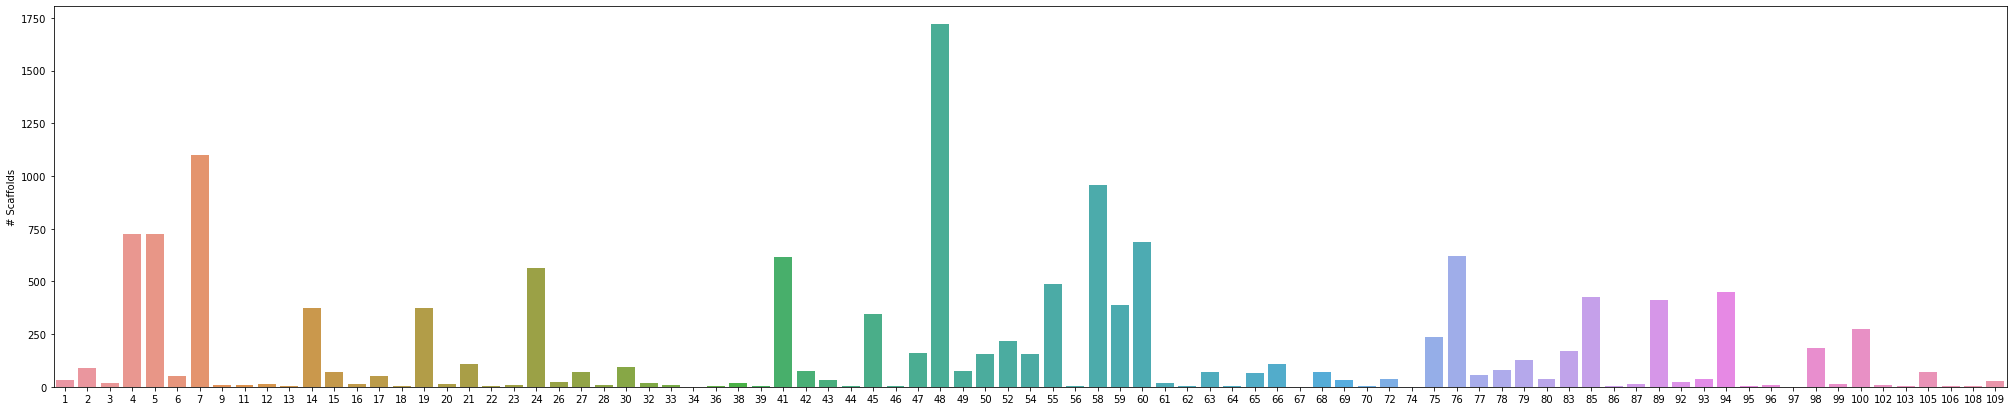

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(35,7))
sns.barplot(x=mg_count.index, y=mg_count.seed_num, ax=ax);
ax.set_ylabel('# Scaffolds');


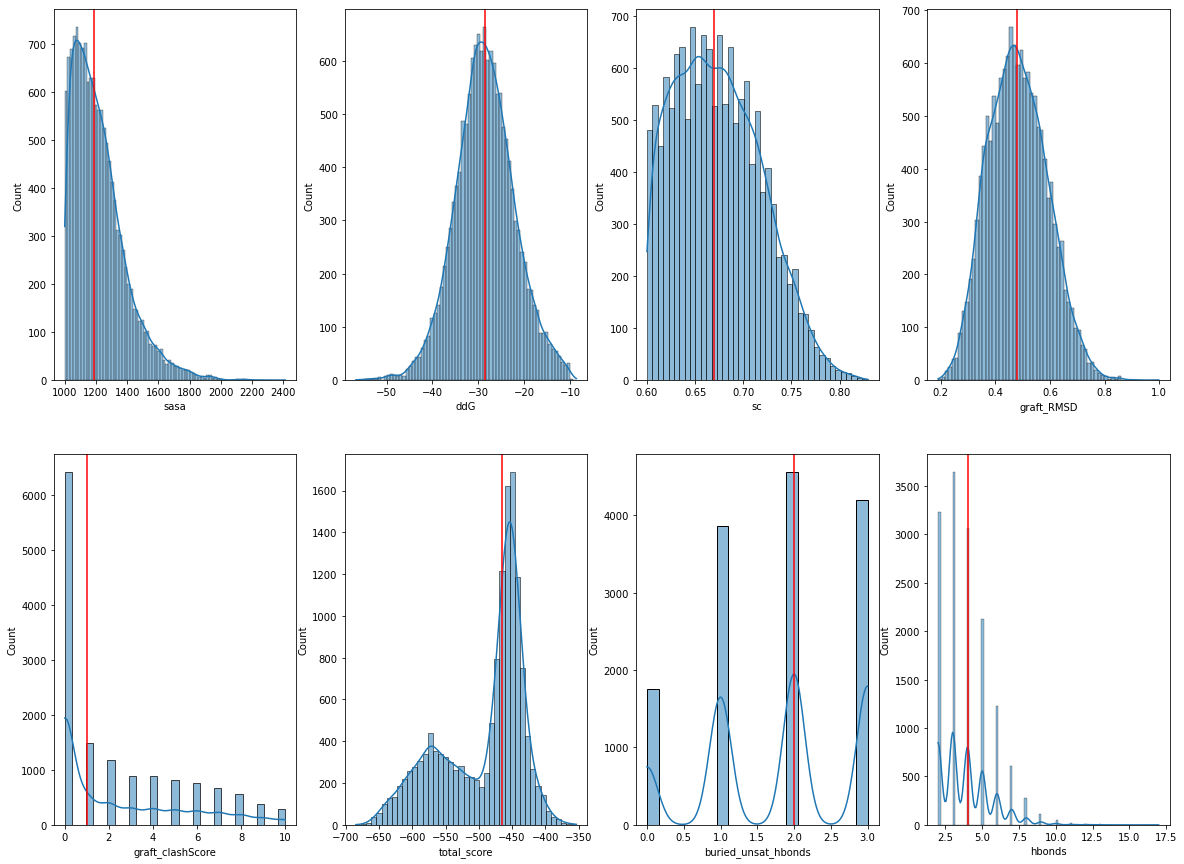

In [30]:
fig, ax = plt.subplots(2, 4, figsize=(20, 15))

# SASA
sns.histplot(
    all_mg_scores_df[all_mg_scores_df["total_score"] < 0]["sasa"], kde=True, ax=ax[0][0]
)
ax[0][0].axvline(all_mg_scores_df["sasa"].median(), color="red")

# ddG
sns.histplot(
    all_mg_scores_df[all_mg_scores_df["total_score"] < 0]["ddG"], kde=True, ax=ax[0][1]
)
ax[0][1].axvline(all_mg_scores_df["ddG"].median(), color="red")

# SC
sns.histplot(
    all_mg_scores_df[all_mg_scores_df["total_score"] < 0]["sc"], kde=True, ax=ax[0][2]
)
ax[0][2].axvline(all_mg_scores_df["sc"].median(), color="red")

# RMSD
sns.histplot(
    all_mg_scores_df[all_mg_scores_df["total_score"] < 0]["graft_RMSD"],
    kde=True,
    ax=ax[0][3],
)
ax[0][3].axvline(all_mg_scores_df["graft_RMSD"].median(), color="red")

# Clashes
sns.histplot(
    all_mg_scores_df[all_mg_scores_df["total_score"] < 0]["graft_clashScore"],
    kde=True,
    ax=ax[1][0],
)
ax[1][0].axvline(all_mg_scores_df["graft_clashScore"].median(), color="red")

# Score
sns.histplot(
    all_mg_scores_df[all_mg_scores_df["total_score"] < 0]["total_score"],
    kde=True,
    ax=ax[1][1],
)
ax[1][1].axvline(all_mg_scores_df["total_score"].median(), color="red")

# BUNS
sns.histplot(
    all_mg_scores_df[all_mg_scores_df["total_score"] < 0]["buried_unsat_hbonds"],
    kde=True,
    ax=ax[1][2],
)
ax[1][2].axvline(all_mg_scores_df["buried_unsat_hbonds"].median(), color="red")

# HBonds
sns.histplot(
    all_mg_scores_df[all_mg_scores_df["total_score"] < 0]["hbonds"],
    kde=True,
    ax=ax[1][3],
)
ax[1][3].axvline(all_mg_scores_df["hbonds"].median(), color="red")


In [31]:
print(f'ddG median:  {all_mg_scores_df["ddG"].median()}')
print(f'total_score median: {all_mg_scores_df["total_score"].median()}')
print(f'sc median: {all_mg_scores_df["sc"].median()}')
print(f'RMSD median: {all_mg_scores_df["graft_RMSD"].median()}')
print(f'clashes median: {all_mg_scores_df["graft_clashScore"].median()}')
print(f'BUNS median: {all_mg_scores_df["buried_unsat_hbonds"].median()}')
print(f'HBonds median: {all_mg_scores_df["hbonds"].median()}')

ddG median:  -28.587
total_score median: -465.672
sc median: 0.67
RMSD median: 0.478
clashes median: 1.0
BUNS median: 2.0
HBonds median: 4.0


In [23]:
all_mg_scores_df.to_pickle(os.path.join(refined_dir, 'all_mg_scores_df.pkl'))

In [13]:
all_mg_scores_df = pd.read_pickle(os.path.join(refined_dir, 'all_mg_scores_df.pkl'))

In [14]:
final_select = all_mg_scores_df[
    (
        all_mg_scores_df["ddg-per-sasa"]
        < np.quantile(all_mg_scores_df["ddg-per-sasa"], 0.75)
    )
    & (all_mg_scores_df["sasa"] >= 1200)
    & (all_mg_scores_df["bunsh-per-sasa"] <= 2)
    & (all_mg_scores_df["sc"] > 0.65)
    & (all_mg_scores_df["hb-per-sasa"] >= 1)
]

final_select.shape


(2095, 53)

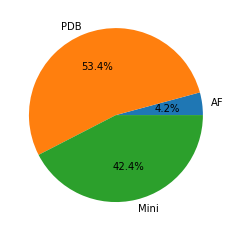

In [124]:
plt.pie([len(final_select.groupby('origin').get_group('AF')), 
len(final_select.groupby('origin').get_group('PDB')), 
len(final_select.groupby('origin').get_group('mini'))],
labels=['AF', 'PDB', 'Mini'],
autopct='%1.1f%%');